# Calculating a Zero Beta Portfolio #

### Daily Rebalancing ###

In [2]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Statistics
import statsmodels.api as sm
from scipy.optimize import minimize

# Manipulate Files
import os

# Pretty Notation
from IPython.display import display, Math

In [3]:
# Get the important data for the Risk Free Rate

rfr = pd.read_csv(r"..\additional_data\rfr.csv")
rfr = rfr.set_index('Date')
rfr.index = pd.to_datetime(rfr.index, dayfirst=True)
rfr.dropna(inplace = True)

# Get the important data for the S&P500

sp500 = pd.read_csv(r"..\additional_data\sp500.csv")
sp500 = sp500.set_index('Date')
sp500.index = pd.to_datetime(sp500.index)

# Get the betas

betas_df = pd.read_csv(r"..\additional_data\betas.csv")
betas_df = betas_df.set_index('Date')
betas_df.index = pd.to_datetime(betas_df.index)

In [4]:
# Dictionary to store the DataFrames
folder_path = r"..\stocks"

dataframes = {} 

# List all files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".csv"):
        # Full path to the file
        file_path = os.path.join(folder_path, file)
        
        # Read the Excel file
        df = pd.read_csv(file_path)
        df = df.set_index("Date")
        df.index = pd.to_datetime(df.index)

        df = df['Adjusted_close']

        df = df.rename("adj_close")
        
        # Fill nans
        df = df.interpolate(method='time')

        df = df.loc['2015-01-01':]

        df.dropna(inplace=True)
        
        if len(df) >= 2000:
            # File name without extension
            file_name = os.path.splitext(file)[0]
            
            # Guardar en el diccionario
            dataframes[file_name] = df
            print(f"File loaded: {file_name} ({len(df)} rows)")
        else:
            print(f"File skipped (less than 2000 rows after cleaning): {file}")

print(f"\nTotal files loaded: {len(dataframes)}")
print("Files loaded:", list(dataframes.keys()))

File loaded: A (2472 rows)
File loaded: AAPL (2472 rows)
File loaded: ABBV (2472 rows)
File skipped (less than 2000 rows after cleaning): ABNB.csv
File loaded: ABT (2472 rows)
File loaded: ADBE (2472 rows)
File loaded: ADI (2472 rows)
File loaded: ADM (2472 rows)
File loaded: ADP (2472 rows)
File loaded: ADSK (2472 rows)
File loaded: AEE (2472 rows)
File loaded: AEP (2472 rows)
File loaded: AES (2472 rows)
File loaded: AFL (2472 rows)
File loaded: AIG (2472 rows)
File loaded: AIZ (2472 rows)
File loaded: AJG (2472 rows)
File loaded: AKAM (2472 rows)
File loaded: ALB (2472 rows)
File loaded: ALGN (2472 rows)
File loaded: ALL (2472 rows)
File loaded: AMAT (2472 rows)
File loaded: AMD (2472 rows)
File loaded: AME (2472 rows)
File loaded: AMGN (2472 rows)
File loaded: AMP (2472 rows)
File loaded: AMT (2472 rows)
File loaded: AMZN (2472 rows)
File loaded: ANET (2472 rows)
File loaded: ANSS (2472 rows)
File loaded: AOS (2472 rows)
File loaded: APA (2472 rows)
File loaded: APD (2472 rows)
Fil

In [5]:
# Create the Returns DataFrame
returns_dict = {}

# Create the Loop to Obtain the Betas
for ticker in dataframes.keys():
    df = dataframes[ticker].pct_change(1).dropna()
    returns_dict[ticker] = df

# Create the DataFrame
df_returns = pd.DataFrame.from_dict(returns_dict)
df_returns = df_returns.apply(lambda x: x.fillna(x.mean()), axis=0)

df_returns

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.018738,-0.028172,-0.018819,0.000223,-0.004976,-0.018275,-0.034602,-0.000720,-0.014614,-0.010002,...,-0.013804,0.000000,-0.017020,-0.011351,-0.027362,-0.062237,-0.020318,0.037303,-0.014077,-0.006003
2015-01-06,-0.015578,0.000094,-0.004950,-0.011356,-0.020144,-0.023384,-0.019713,-0.008350,-0.019775,-0.011641,...,-0.017107,-0.001108,-0.021331,0.005321,-0.005316,-0.005881,-0.012274,-0.008477,-0.007205,-0.009756
2015-01-07,0.013272,0.014022,0.040417,0.008108,0.008223,0.010516,0.015031,0.008784,-0.002087,0.007778,...,0.016218,0.003050,0.029368,0.008635,0.010133,0.007887,0.033138,0.024870,0.025465,0.020643
2015-01-08,0.029975,0.038422,0.010459,0.020554,0.025383,0.017655,-0.014609,0.022940,0.024747,0.003528,...,0.019657,0.010779,0.012031,0.011599,0.016645,0.007546,0.017420,0.010617,0.021359,0.015399
2015-01-09,-0.007337,0.001072,-0.027355,-0.010508,-0.014743,-0.000730,-0.008530,-0.007162,-0.009014,-0.011206,...,-0.011453,-0.001367,0.012499,-0.012285,-0.001410,-0.018863,-0.001767,-0.014424,0.014613,0.001584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,-0.024130,-0.002622,0.011901,-0.007437,-0.009242,-0.004653,-0.007839,0.001478,-0.004486,-0.005327,...,-0.002959,-0.019820,0.010471,0.003941,0.005163,-0.008678,-0.004776,-0.008935,-0.001584,0.000317
2024-10-23,-0.003222,-0.021623,-0.004662,0.007664,-0.016386,0.009928,0.007003,-0.004462,-0.007574,0.016408,...,0.000140,0.006319,-0.017304,0.010050,-0.003563,0.002664,0.004949,0.004220,-0.010511,-0.002744
2024-10-24,-0.017590,-0.000823,0.009421,-0.004017,-0.004453,0.012475,0.007489,-0.002103,-0.001834,-0.002130,...,0.154343,0.008791,0.002252,0.012282,-0.005654,-0.008123,-0.006417,-0.006686,-0.016409,-0.039632


In [6]:
# Common Index

common_index = df_returns.index.intersection(betas_df.index)  # Common DATE
df_returns_reindex = df_returns.reindex(common_index)
df_betas_reindex = betas_df.reindex(common_index)

In [7]:
# Calculate the Correlations Matrix
corr_matrix = df_returns_reindex.corr().values  

# Obtain Eigenvalues
eigenvalues, _ = np.linalg.eigh(corr_matrix)

# Identify how much Eigenvalues are small (high colineality)
threshold = 1e-4  # Adjust
num_redundant = sum(eigenvalues < threshold)

print(f"Number of highly colineal variables: {num_redundant}")

Number of highly colineal variables: 0


In [8]:
# Define the Function
def calculate_zbp(returns_df, betas_df, rebalance_period='D'):
    """
    Calculate the Zero Beta Portfolio (ZBP) daily returns over time.

    Parameters:
    - returns_df: DataFrame of daily returns of 399 assets.
    - betas_df: DataFrame of daily betas of 399 assets.
    - rebalance_period: The period for rebalancing ('M' for monthly, 'W' for weekly, etc.)

    Returns:
    - zbp_returns: Series of daily returns for the Zero Beta Portfolio.
    """

    # Initialize the series to hold ZBP returns
    zbp_returns = pd.Series(index=returns_df.index)

    # Resampling based on the rebalance period (monthly in this case)
    rebalance_dates = returns_df.resample(rebalance_period).first().index

    # Variable to store the last computed weights
    last_weights = None

    # Iterate over all dates
    for date in returns_df.index:
        if date in rebalance_dates:
            # Subset the data for the current rebalance period
            subset_returns = returns_df.loc[date]
            subset_betas = betas_df.loc[date]

            # Ensure no NaN values (drop any assets with missing data)
            valid_assets = (~subset_returns.isna()) & (~subset_betas.isna())
            subset_returns = subset_returns[valid_assets]
            subset_betas = subset_betas[valid_assets]

            # Number of assets in the current subset
            n_assets = len(subset_returns)
            if n_assets == 0:
                continue  # Skip this date if there are no valid 

            # Scale betas
            subset_betas = subset_betas / subset_betas.std()

            # Objective function: minimize the sum of squared weights
            def objective(weights):
                return np.dot(weights, weights)  

            # Constraints:
            constraints = [
                {'type': 'eq', 'fun': lambda weights: np.sum(np.abs(weights)) - 1},  # Long-short balance
                {'type': 'eq', 'fun': lambda weights: np.dot(weights, subset_betas)}  # Zero beta
            ]

            # Bounds for the weights (allowing short-selling)
            bounds = [(-1, 1)] * n_assets  

            # Initial guess (equally weighted portfolio)
            initial_guess = np.ones(n_assets) / n_assets

            # Solve the optimization problem
            result = minimize(objective, initial_guess, bounds=bounds, constraints=constraints)

            if result.success:
                last_weights = pd.Series(result.x, index=subset_returns.index)

        # If we have weights, apply them to get the daily return
        if last_weights is not None:
            available_assets = returns_df.loc[date].dropna()
            common_assets = last_weights.index.intersection(available_assets.index)
            zbp_returns[date] = np.dot(last_weights[common_assets], available_assets[common_assets])

    return zbp_returns.dropna()


In [9]:
print(df_returns_reindex.shape)
print(df_betas_reindex.shape)

(2168, 399)
(2168, 399)


In [10]:
# Calculate the ZBP

zbp_returns = calculate_zbp(df_returns_reindex, df_betas_reindex)

zbp_returns.mul(100)

Date
2016-02-26   -0.506193
2016-02-29   -0.191617
2016-03-01   -0.092655
2016-03-02   -0.314060
2016-03-03   -0.076501
                ...   
2024-10-22   -0.163407
2024-10-23    0.090459
2024-10-24   -0.407154
2024-10-25   -0.639395
2024-10-28    0.219105
Length: 2168, dtype: float64

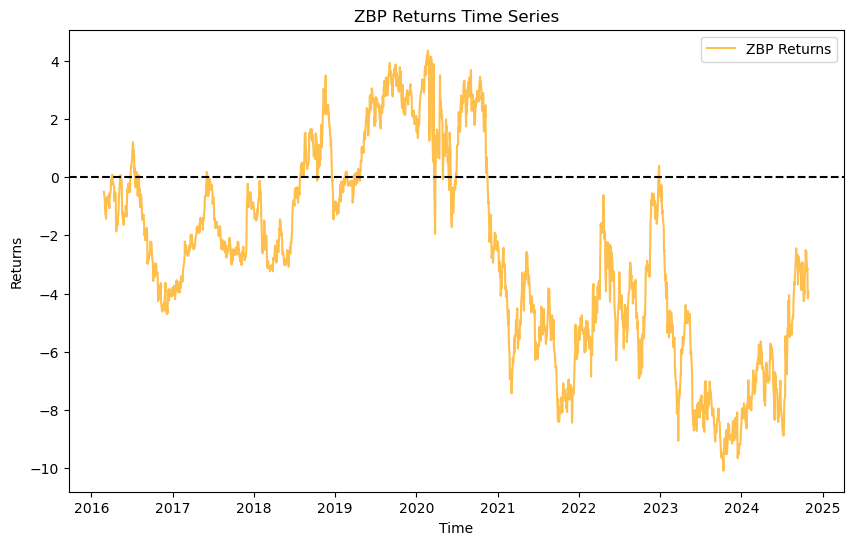

In [11]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(zbp_returns.mul(100).cumsum(), label='ZBP Returns', color='orange', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('ZBP Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()

# Show
plt.show()

In [12]:
# Calculate the beta
risk_free_daily = (((1 + (rfr['risk_free_rate'].div(100)))**(1/360)) - 1)

df_regression = pd.DataFrame()
df_regression['y'] = zbp_returns - risk_free_daily
df_regression['x'] = sp500['sp_500'].pct_change(1) - risk_free_daily
df_regression.dropna(inplace = True)
df_regression = df_regression.mul(100)

df_regression

,y,x
Date,,
2016-02-26,-0.511039,-0.191858
2016-02-29,-0.196409,-0.816890
2016-03-01,-0.097692,2.381842
2016-03-02,-0.319125,0.404366
2016-03-03,-0.081538,0.344837
...,...,...
2024-10-22,-0.174836,-0.058914
2024-10-23,0.078924,-0.930668
2024-10-24,-0.418609,0.203122


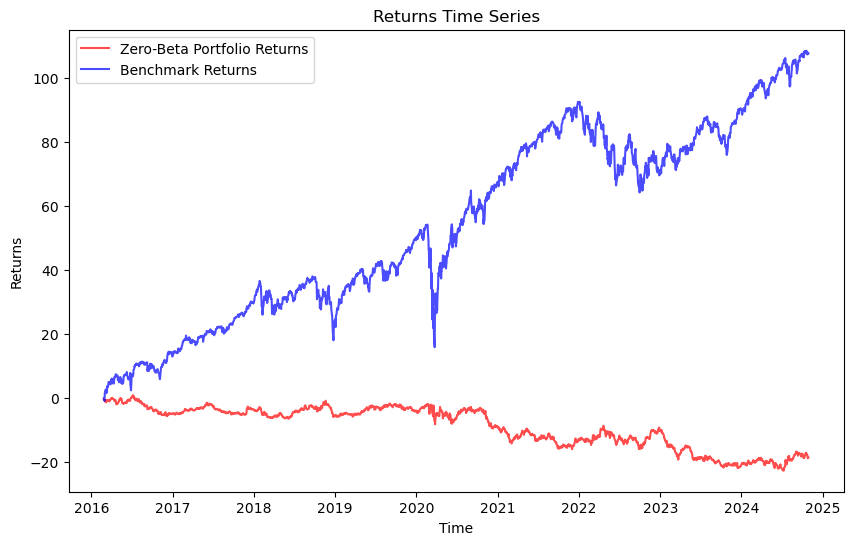

In [13]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(df_regression['y'].cumsum(), label='Zero-Beta Portfolio Returns', color='red', alpha=0.7)
plt.plot(df_regression['x'].cumsum(), label='Benchmark Returns', color='blue', alpha=0.7)

# Config
plt.title('Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()

# Show
plt.show()

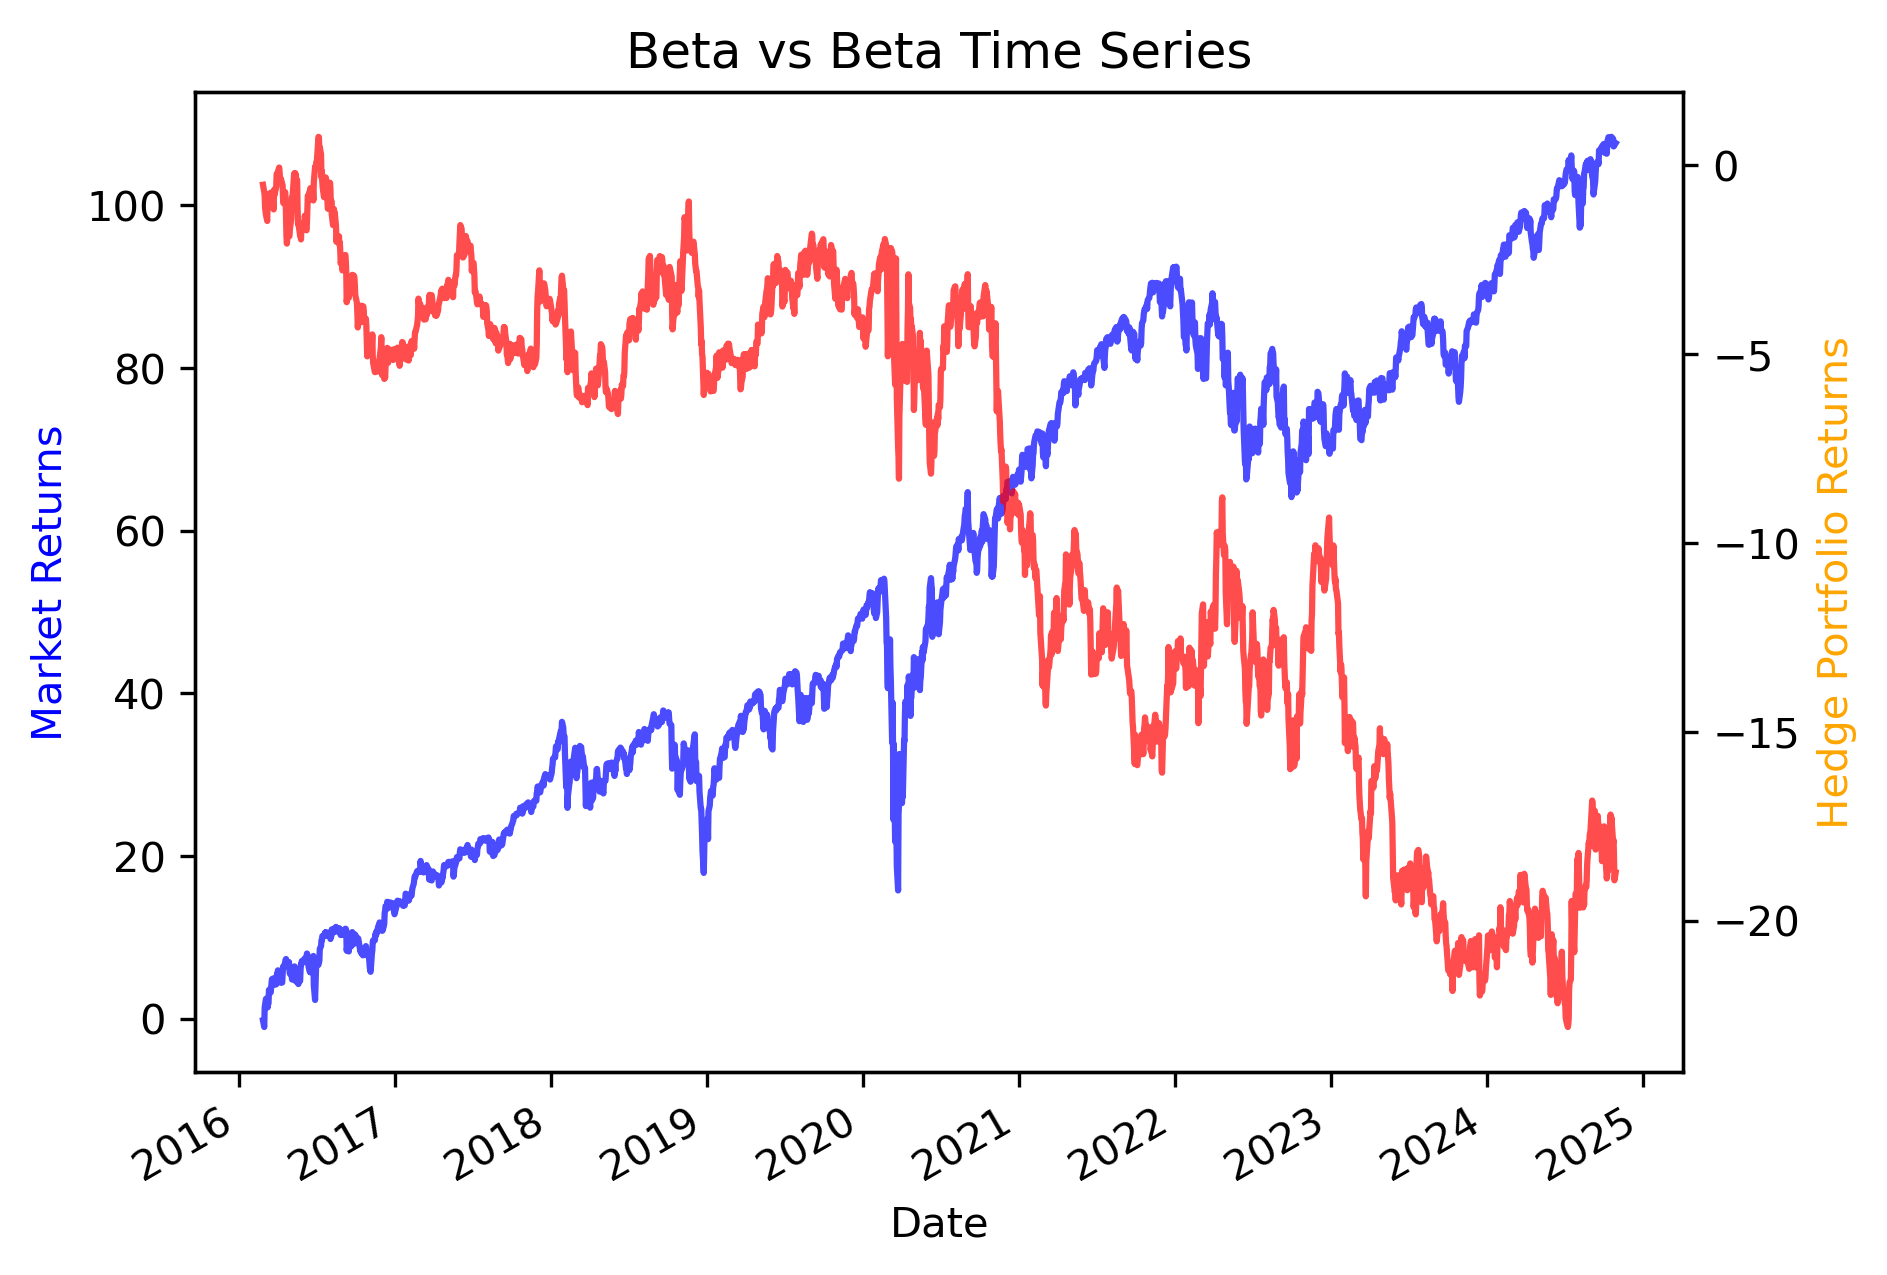

In [14]:
# Create Figure
fig, ax1 = plt.subplots(dpi = 300)

# Market Returns Plot
df_regression['x'].cumsum().plot(color = 'blue', ax = ax1, alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel(
    'Market Returns', 
    color='blue'
    )

# ZBP Returns Plot
ax2 = ax1.twinx()

df_regression['y'].cumsum().plot(color = 'red', ax = ax2, alpha=0.7)
ax2.set_ylabel(
    'Hedge Portfolio Returns', 
    color='orange'
    )

plt.title('Beta vs Beta Time Series')
plt.show()

In [15]:
# Correlation between market and our hedge portfolio

df_regression.corr()

,y,x
y,1.00000,0.13379
x,0.13379,1.00000


In [16]:
# Create the Weights function
def wexp(N, half_life):
    c = np.log(0.5)/half_life
    n = np.array(range(N))
    w = np.exp(c*n)
    return np.flip(w/np.sum(w))

In [17]:
#Model specification
window = len(df_regression)
weights = window * wexp(window, window/2)

model = sm.WLS(
    df_regression['y'], 
    sm.add_constant(df_regression['x']),
    missing='drop',
    weights=weights
    )   
     
#the results of the model
results = model.fit() 
    
#here we check the summary
print(results.summary()) 

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.014
Model:                            WLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     30.94
Date:                Mon, 07 Apr 2025   Prob (F-statistic):           2.99e-08
Time:                        19:25:59   Log-Likelihood:                -970.54
No. Observations:                2168   AIC:                             1945.
Df Residuals:                    2166   BIC:                             1956.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0106      0.008     -1.348      0.1

In [18]:
# Set rolling window size
window = 252
weights = window * wexp(window, window/2)

y = df_regression['y']
x = sm.add_constant(df_regression['x'])

# Lists to store rolling coefficients
params = []
index = []
lower_bounds = []
upper_bounds = []

# Rolling regression
for i in range(window, len(df_regression)):
    Y_window = y.iloc[i - window:i]
    X_window = x.iloc[i - window:i]

    # Fit WLS model
    model = sm.WLS(Y_window, X_window, missing='drop', weights=weights).fit()

    # Store coefficients (const, X1, X2)
    params.append(model.params.values)
    index.append(df_regression.index[i])  # Use the last date of the window

    # Store lower and upper bounds of 95% confidence intervals
    ci = model.conf_int(alpha=0.05)  # 95% CI
    lower_bounds.append(ci.iloc[:, 0].values)  # First column: lower bound
    upper_bounds.append(ci.iloc[:, 1].values)  # Second column: upper bound


In [19]:
# Convert list of coefficients to DataFrame
parameters_df = pd.DataFrame(params, columns=x.columns, index=index)

parameters_df

,const,x
2017-03-01,-0.010177,0.021485
2017-03-02,-0.010824,0.013069
2017-03-03,-0.008614,0.009412
2017-03-06,-0.009410,0.010796
2017-03-07,-0.009196,0.011663
...,...,...
2024-10-22,0.019635,-0.033262
2024-10-23,0.018610,-0.033492
2024-10-24,0.019069,-0.034219
2024-10-25,0.016768,-0.035090


In [20]:
# Lower bounds DataFrame
lower_df = pd.DataFrame(lower_bounds, columns=[f'{col}_lower' for col in x.columns], index=index)

lower_df

,const_lower,x_lower
2017-03-01,-0.040066,-0.027779
2017-03-02,-0.040744,-0.035497
2017-03-03,-0.038506,-0.039155
2017-03-06,-0.039223,-0.038457
2017-03-07,-0.038861,-0.037446
...,...,...
2024-10-22,-0.026966,-0.091150
2024-10-23,-0.027904,-0.091491
2024-10-24,-0.027279,-0.092018
2024-10-25,-0.029640,-0.093111


In [21]:
# Upper bounds DataFrame
upper_df = pd.DataFrame(upper_bounds, columns=[f'{col}_upper' for col in x.columns], index=index)

upper_df

,const_upper,x_upper
2017-03-01,0.019712,0.070749
2017-03-02,0.019095,0.061635
2017-03-03,0.021278,0.057978
2017-03-06,0.020402,0.060048
2017-03-07,0.020468,0.060771
...,...,...
2024-10-22,0.066237,0.024625
2024-10-23,0.065124,0.024506
2024-10-24,0.065418,0.023580
2024-10-25,0.063175,0.022931


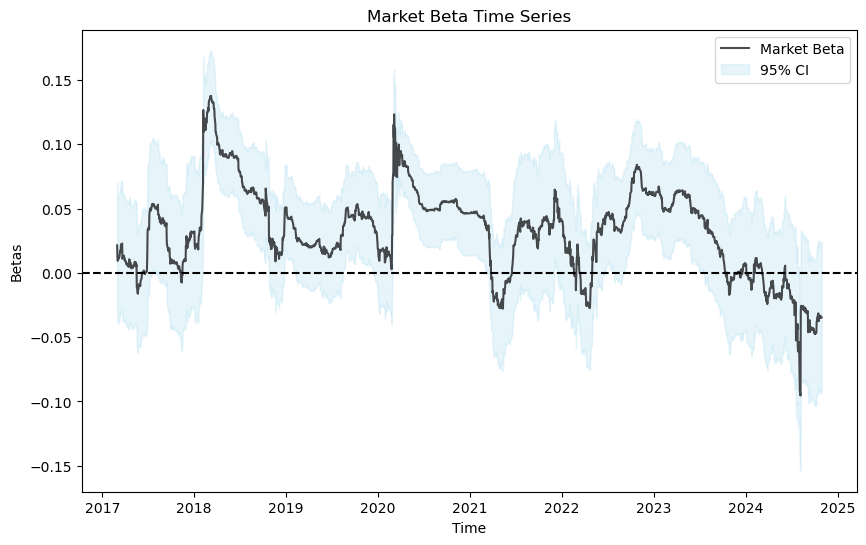

In [22]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(parameters_df['x'], label='Market Beta', color='black', alpha=0.7)
plt.fill_between(upper_df.index, lower_df['x_lower'], upper_df['x_upper'], color='skyblue', alpha=0.2, label='95% CI')
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('Market Beta Time Series')
plt.xlabel('Time')
plt.ylabel('Betas')
plt.legend()

# Show
plt.show()

In [23]:
zbp_returns.name = 'zero_beta_portfolio'
# zbp_returns.to_csv(r"..\additional_data\zero_beta.csv", header=True)